Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
27 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
5 input query terms found no hit:	['ENSG00000250410', 'ENSG00000168078', 'ENSG00000266957', 'ENSG00000189144', 'ENSG00000267058']


转换后的前10个基因名：
Index(['ENSG00000241860', 'ENSG00000241599', 'ENSG00000229905', 'LINC01409',
       'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'ENSG00000272438',
       'LINC02593'],
      dtype='object')
✅ CD3D 已找到
✅ CD3E 已找到
✅ CD19 已找到
✅ MS4A1 已找到
✅ CD14 已找到
✅ FCGR3A 已找到


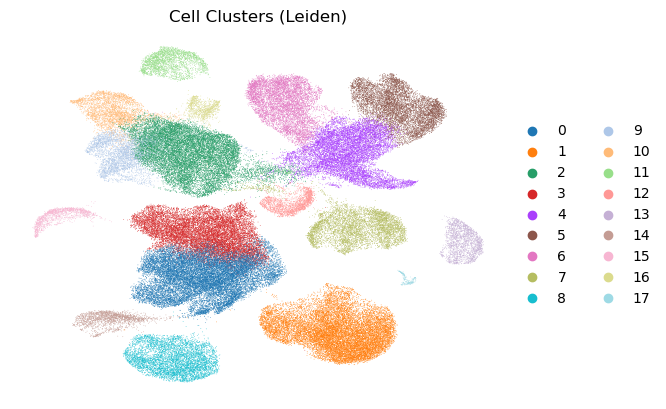

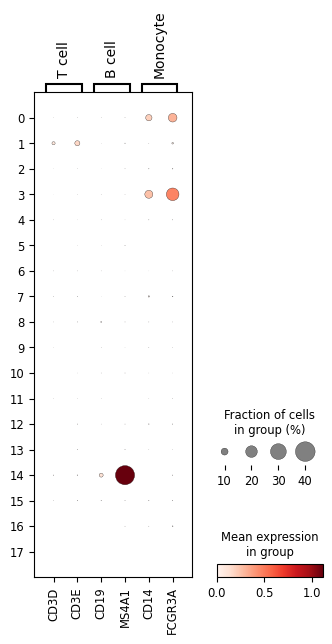

是否生成dpt_pseudotime: True


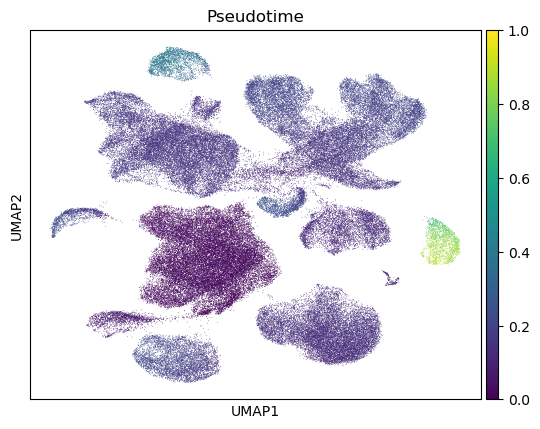

AttributeError: module 'scvelo' has no attribute 'read'

In [9]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv
import seaborn as sns
import mygene  # 新增：导入ID转换工具

# 1.1 加载数据
adata = sc.read_h5ad('lung_atlas_of_lethal_COVID-19.h5ad')

# ========== 新增：Ensembl ID 转 基因符号 ==========
# 初始化mygene工具
mg = mygene.MyGeneInfo()

# 提取所有Ensembl ID（去重，避免重复转换）
ensembl_ids = adata.var_names.unique().tolist()

# 批量查询：Ensembl ID → 基因符号（人类数据集用species='human'）
# 关键参数：scopes指定输入是Ensembl ID，fields指定输出基因符号，species指定物种
query_results = mg.querymany(
    ensembl_ids,
    scopes='ensembl.gene',  # 输入是Ensembl基因ID
    fields='symbol',        # 输出基因符号
    species='human',        # 人类数据集（小鼠用'mouse'）
    returnall=True,         # 返回所有结果（包括匹配失败的）
    verbose=True            # 显示进度
)

# 构建「Ensembl ID → 基因符号」的映射字典
id2symbol = {}
for item in query_results['out']:
    # 跳过匹配失败/无基因符号的ID
    if 'symbol' in item and item['symbol'] is not None:
        id2symbol[item['query']] = item['symbol']

# 替换adata的基因名（var_names）为基因符号
# 对匹配失败的ID，保留原Ensembl ID（避免丢失）
new_var_names = [id2symbol.get(ens_id, ens_id) for ens_id in adata.var_names]
adata.var_names = new_var_names

# 关键：去除重复的基因符号（同一基因可能对应多个Ensembl ID）
adata = adata[:, ~adata.var_names.duplicated()]  # 保留第一个出现的基因

# 验证转换结果：查看前10个转换后的基因名
print("转换后的前10个基因名：")
print(adata.var_names[:10])

# 验证目标marker基因是否存在（不区分大小写）
marker_genes_check = ['CD3D', 'CD3E', 'CD19', 'MS4A1', 'CD14', 'FCGR3A']
for gene in marker_genes_check:
    if gene in adata.var_names:
        print(f"✅ {gene} 已找到")
    else:
        print(f"❌ {gene} 仍未找到（可能该数据集无此基因表达）")

# 1.2 基础过滤（去除低质量细胞/基因）
# 过滤标准可根据数据集调整
sc.pp.filter_cells(adata, min_genes=200)  # 细胞至少表达200个基因
sc.pp.filter_genes(adata, min_cells=3)    # 基因至少在3个细胞中表达

# 1.3 线粒体基因过滤（去除凋亡细胞）
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # 人类线粒体基因前缀MT-
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs['pct_counts_mt'] < 10, :]  # 线粒体比例<10%

# 1.4 归一化与对数转换
sc.pp.normalize_total(adata, target_sum=1e4)  # 归一化到10000 UMI
sc.pp.log1p(adata)  # 对数转换

# 1.5 高变基因筛选（用于降维）
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata  # 保存原始数据
adata = adata[:, adata.var.highly_variable]

# 1.6 数据缩放（均值0，方差1）
sc.pp.scale(adata, max_value=10)

# 1.7 降维（PCA + UMAP）
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)  # 构建近邻图
sc.tl.umap(adata)  # UMAP降维可视化
# 2.1 细胞聚类（Leiden算法，比Louvain更优）
sc.tl.leiden(adata, resolution=0.5)  # resolution调整聚类精细度

# 2.2 可视化聚类结果
sc.pl.umap(adata, color=['leiden'], title='Cell Clusters (Leiden)', frameon=False)

# 2.3 细胞类型注释（两种方式）
# 方式1：手动注释（基于已知marker基因）
marker_genes = {
    'T cell': ['CD3D', 'CD3E'],
    'B cell': ['CD19', 'MS4A1'],
    'Monocyte': ['CD14', 'FCGR3A']
}
# 可视化marker基因表达
sc.pl.dotplot(adata, marker_genes, groupby='leiden',use_raw=True)

# 方式2：自动注释（使用scANVI/CellTypist，需额外安装）
# from celltypist import models, Pipeline
# model = models.Model.load('Immune_All_Low.pkl')
# predictions = Pipeline(adata).predict(model=model)
# adata.obs['cell_type'] = predictions.predicted_labels

# 2.4 保存分群后数据
adata.write_h5ad('clustered_data.h5ad')
# 3.1 重新加载分群数据（如需）
adata = sc.read_h5ad('clustered_data.h5ad')

# 3.2 拟时序分析（Monocle3算法，兼容Scanpy<1.9.0）
sc.tl.diffmap(adata)  # 扩散映射

# 选择根细胞并指定到adata.uns['iroot']
cluster_sizes = adata.obs['leiden'].value_counts()
largest_cluster = cluster_sizes.index[0]
root_cell = adata.obs_names[adata.obs['leiden'] == largest_cluster][0]
root_idx = adata.obs_names.get_loc(root_cell)  # 转细胞名到索引
adata.uns['iroot'] = root_idx  # 低版本核心配置

# 运行DPT（无root_cell参数）
sc.tl.dpt(adata, n_dcs=10)

# 验证伪时间列是否生成
print("是否生成dpt_pseudotime:", 'dpt_pseudotime' in adata.obs)  # 应输出True

# 3.3 可视化伪时间
sc.pl.umap(adata, color=['dpt_pseudotime'], cmap='viridis', title='Pseudotime')


# 3.4 RNA速率分析（更精准的分化方向）
# 加载spliced/unspliced计数数据（10X Velocyto输出）
ldata = scv.read('velocyto_output.loom', cache=True)
adata = scv.utils.merge(adata, ldata)

# RNA速率计算
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

# 可视化RNA速率
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

# 3.5 保存轨迹分析数据
adata.write_h5ad('trajectory_data.h5ad')
# 4.1 筛选伪时间相关基因
# 方法1：相关性分析
pseudotime = adata.obs['dpt_pseudotime'].values
gene_expr = adata.X.toarray()  # 表达矩阵（稀疏矩阵转密集）
corr = []
for i in range(gene_expr.shape[1]):
    corr.append(np.corrcoef(gene_expr[:, i], pseudotime)[0, 1])
adata.var['pseudotime_corr'] = corr

# 筛选高相关性基因（|r|>0.5）
corr_genes = adata.var_names[np.abs(adata.var['pseudotime_corr']) > 0.5]
print(f'Pseudotime correlated genes: {len(corr_genes)}')

# 方法2：差异表达分析（分支特异性）
# 定义分化起点和终点群
start_cluster = '0'  # 需根据实际分群调整
end_cluster = '5'
adata.obs['branch'] = 'other'
adata.obs.loc[adata.obs['leiden'] == start_cluster, 'branch'] = 'start'
adata.obs.loc[adata.obs['leiden'] == end_cluster, 'branch'] = 'end'

# 计算分支间DEG
sc.tl.rank_genes_groups(adata, groupby='branch', groups=['end'], reference='start', method='wilcoxon')
deg_results = sc.get.rank_genes_groups_df(adata, group='end')
# 筛选显著DEG（padj<0.05，log2FC>1）
sig_deg = deg_results[(deg_results['padj'] < 0.05) & (deg_results['logfoldchanges'] > 1)]
print(f'Significant DEGs: {len(sig_deg)}')

# 4.2 转录因子调控网络分析（Pyscenic）
import pyscenic as ps
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

# 加载人类TF列表（需提前下载）
tf_list = pd.read_csv('human_tfs.csv')['Symbol'].tolist()

# 加载排名数据库（需下载：https://resources.aertslab.org/cistarget/）
db_files = ['hg38_tss_10kb_up_10kb_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather']
dbs = [RankingDatabase(fname=f) for f in db_files]

# 构建共表达模块
adj = ps.grnboost2(adata.to_df(), tf_list=tf_list, verbose=True)
modules = list(modules_from_adjacencies(adj, adata.to_df()))

# 修剪模块得到调控子
df = prune2df(dbs, modules, tf_list)
regulons = df2regulons(df)

# 计算AUCell分数（调控子活性）
adata.obs['aucell'] = aucell(adata.to_df(), regulons)

# 筛选核心TF（高AUCell分数+伪时间高相关）
core_tfs = [tf for tf in tf_list if tf in corr_genes and adata.obs['aucell'].mean() > 0.5]
print(f'Core TFs driving differentiation: {core_tfs}')

# 4.3 可视化关键基因
# 热图：伪时间相关基因表达
top_genes = corr_genes[:50]
sc.pl.heatmap(adata, top_genes, groupby='leiden', cmap='viridis', dendrogram=True)

# 小提琴图：核心TF在不同分群的表达
sc.pl.violin(adata, core_tfs, groupby='leiden', rotation=90)

# 4.4 保存关键基因列表
sig_deg.to_csv('differentiation_genes.csv', index=False)
pd.DataFrame(core_tfs, columns=['Core_TFs']).to_csv('core_tfs.csv', index=False)

In [11]:
# 检查扩散映射结果（DPT依赖）
print("是否存在X_diffmap:", 'X_diffmap' in adata.obsm)
# 检查近邻图（diffmap依赖）
print("是否存在connectivities:", 'connectivities' in adata.obsp)
# 检查Leiden聚类（可选，但建议有）
print("是否存在leiden分群:", 'leiden' in adata.obs)

# 若上述结果为False，重新运行前置步骤
if 'connectivities' not in adata.obsp:
    # 重新运行PCA+近邻图构建
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

if 'X_diffmap' not in adata.obsm:
    # 重新运行扩散映射
    sc.tl.diffmap(adata, n_comps=10)  # n_comps指定扩散映射维度

是否存在X_diffmap: True
是否存在connectivities: True
是否存在leiden分群: True
